### Convergent Recombination in Embedding Space
Investigate the distribution of convergent recombination in embedding space created by the CVC.

In [2]:
cd ..

/home/romi/projects/preTCR


#### Set Environment

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, sys
import collections
import importlib
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import anndata as ad
import scanpy as sc

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from cvc import plot_utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

#### Prepare data

In [8]:
data_dir = DATA_DIR + "db_data_nuc_vj_genes_pub_priv.csv"

In [9]:
# load data
tcrb_data = pd.read_csv(data_dir, usecols=["Sequences", "Private_Public_label", "nSeqCDR3"], engine="pyarrow")
tcrb_data.head()

,Sequences,Private_Public_label,nSeqCDR3
0,CASSLGETQYF,1,TGTGCCAGCAGTTTAGGAGAGACCCAGTACTTC
1,CASSLGETQYF,1,TGTGCCAGCAGCTTGGGAGAGACCCAGTACTTC
2,CASSLGETQYF,1,TGCGCCAGCAGCTTGGGGGAGACCCAGTACTTC
3,CASSLGETQYF,1,TGCGCCAGCAGCTTGGGCGAGACCCAGTACTTC
4,CASSLGETQYF,1,TGTGCCAGCAGTTTAGGGGAGACCCAGTACTTC


In [10]:
len(tcrb_data)

199455320

#### Calculate and Display Convergent Recombination

In [12]:
# for db data read above
tcrb_data_nseq = tcrb_data
len(tcrb_data_nseq.index)

199455320

In [13]:
# extract sequences
tcrb_data_nseq_seq_only = tcrb_data_nseq[['Sequences', 'nSeqCDR3']]
tcrb_data_nseq_seq_only

,Sequences,nSeqCDR3
0,CASSLGETQYF,TGTGCCAGCAGTTTAGGAGAGACCCAGTACTTC
1,CASSLGETQYF,TGTGCCAGCAGCTTGGGAGAGACCCAGTACTTC
2,CASSLGETQYF,TGCGCCAGCAGCTTGGGGGAGACCCAGTACTTC
3,CASSLGETQYF,TGCGCCAGCAGCTTGGGCGAGACCCAGTACTTC
4,CASSLGETQYF,TGTGCCAGCAGTTTAGGGGAGACCCAGTACTTC
...,...,...
199455315,CAWNAGTEANQPQHF,TGTGCCTGGAATGCCGGGACCGAGGCCAATCAGCCCCAGCATTTT
199455316,CARGEGATLGGRVYFDYW,TGTGCGAGGGGGGAGGGAGCAACTTTGGGGGGAAGAGTCTACTTTG...
199455317,CASSVHRLRTEAFF,TGTGCCAGCAGCGTACACCGGTTAAGGACTGAAGCTTTCTTT
199455318,CSASTTERGNTDTQYF,TGCAGTGCTAGTACGACCGAACGGGGGAACACAGATACGCAGTATTTT


In [13]:
tcrb_data_nseq_seq_only = tcrb_data_nseq_seq_only.drop_duplicates()
len(tcrb_data_nseq_seq_only)

162710891

In [14]:
# Count how many unique nSeqCDR3 are there per each Sequence group in tcrb_data_nseq_seq_only
df_counts = tcrb_data_nseq_seq_only.groupby('Sequences').count()
df_counts = df_counts.rename(columns={'nSeqCDR3': 'CR_num'})

In [ ]:
stats = collections.Counter(df_counts['CR_num'])
stats

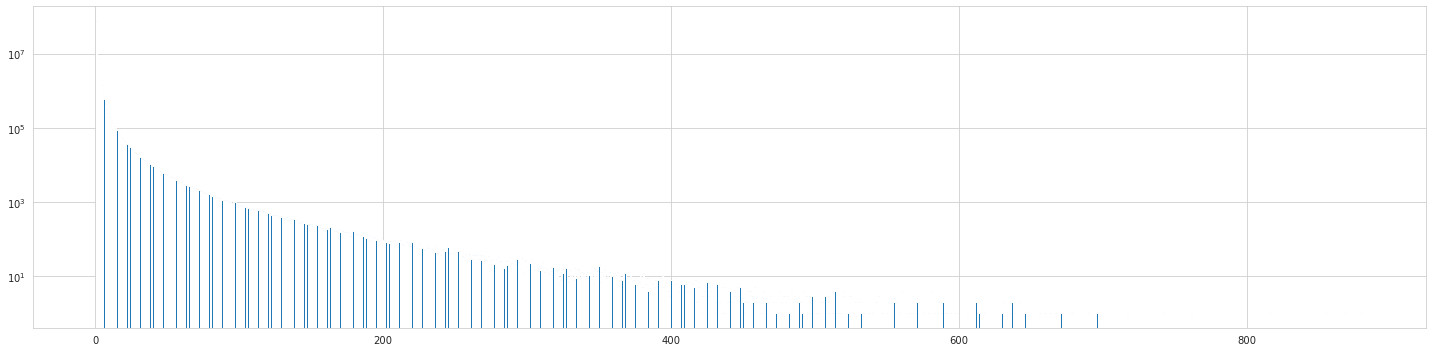

In [18]:
# bar plot for stats
plt.bar(stats.keys(), stats.values())
# change y axis to log scale
plt.yscale('log')
# make the plot larger
plt.gcf().set_size_inches(20, 5)
# wider bars for better visualization
plt.tight_layout()
# show plot
plt.show()

In [19]:
# divide into bins
df_counts['CR_bin'] = pd.cut(df_counts.CR_num, bins=[0, 100, 200, 300, 400, 1000], labels=['0-100', '100-200', '200-300', '300-400', '400+'])
df_counts.CR_bin.value_counts()

0-100      91721765
100-200       30799
200-300        4574
300-400        1132
400+            427
Name: CR_bin, dtype: int64

In [20]:
# look at df_counts
df_counts

,CR_num,CR_bin
Sequences,,
A,3,0-100
AAAEGTREQYF,1,0-100
AAAFF,1,0-100
AAAFYQETQYF,1,0-100
AAAGGDKRGYYYYGMDVW,1,0-100
...,...,...
YYYYMDVW,1,0-100
YYYYNYMDVW,1,0-100
YYYYYMDVW,1,0-100


In [21]:
df_counts.index.name = 'Sequences'
df_counts.reset_index(inplace=True)
df_counts = df_counts.rename(columns={'CR_bin': 'CR_bin_range'})
df_counts.head()

,Sequences,CR_num,CR_bin
0,A,3,0-100
1,AAAEGTREQYF,1,0-100
2,AAAFF,1,0-100
3,AAAFYQETQYF,1,0-100
4,AAAGGDKRGYYYYGMDVW,1,0-100


In [23]:
df_counts_small = df_counts

In [24]:
# Resamples df_counts into df_counts_small
# df_counts_small will contain 10% of the data from df_counts for each group by CR_num
def filter_data(df):
    if len(df) < 40000: # this number depends on the dataset and distribution of CR_num
        return df
    return df.sample(n=500_000)

df_counts_small = df_counts.groupby('CR_bin_range').apply(filter_data)
df_counts_small.head()

Sequences  CR_num CR_bin_range
CR_bin_range                                                
0-100        14568217    CASRSSGRLYEQYF       9        0-100
             25067575  CASSHGGRRGSYEQYF       1        0-100
             18852168     CASSEGGGNRAFF       1        0-100
             9375574    CASNGRQNPDNEQFF       1        0-100
             73009535  CATSRVEGGGPDMQYF       1        0-100

In [25]:
len(df_counts_small.index)

536932

In [26]:
df_counts_small.CR_bin_range.value_counts()

0-100      500000
100-200     30799
200-300      4574
300-400      1132
400+          427
Name: CR_bin_range, dtype: int64

In [27]:
# merge CR number to general dataframe
# tcrb_data_sample_concatinated = pd.merge(tcrb_data_nseq, df_counts, on='Sequences')
# tcrb_data_sample = tcrb_data_sample_concatinated
# tcrb_data_sample
tcrb_data_sample = df_counts_small

In [28]:
df_counts_small

Sequences  CR_num CR_bin_range
CR_bin_range                                                
0-100        14568217    CASRSSGRLYEQYF       9        0-100
             25067575  CASSHGGRRGSYEQYF       1        0-100
             18852168     CASSEGGGNRAFF       1        0-100
             9375574    CASNGRQNPDNEQFF       1        0-100
             73009535  CATSRVEGGGPDMQYF       1        0-100
...                                 ...     ...          ...
400+         54983654     CASSSGLNTEAFF     450         400+
             55168182     CASSSGSSYEQYF     462         400+
             55171325      CASSSGSYEQYF     426         400+
             55215522    CASSSGTGSYEQYF     430         400+
             57228205    CASSSSGGSYEQYF     403         400+

[536932 rows x 3 columns]

In [29]:
tcrb_data_priv_pub = tcrb_data_nseq[['Sequences', 'Private_Public_label']]

In [31]:
tcrb_data_priv_pub = tcrb_data_priv_pub.loc[tcrb_data_priv_pub['Sequences'].isin(df_counts_small['Sequences'])]
tcrb_data_priv_pub.drop_duplicates()

,Sequences,Private_Public_label
0,CASSLGETQYF,1
16658,CASSLGYEQYF,1
30397,CASSLGGNTEAFF,1
43085,CASSSSYEQYF,1
54734,CASSLQETQYF,1
...,...,...
199454889,CASSRTRTGVYQETQYF,0
199454904,CSATDRGFGGSNQPQHF,0
199454922,CASSIVGGHSYGYTF,0
199455162,CASSVHLEGGTEAFF,0


In [38]:
# add to df_counts_small a Private_Public_label column from tcrb_data_priv_pub by merging on Sequences column
tcrb_data_sample = pd.merge(df_counts_small, tcrb_data_priv_pub, on='Sequences')
tcrb_data_sample.drop_duplicates(inplace=True)
collections.Counter(tcrb_data_sample['Private_Public_label'])

#### Create and Display embeddings

In [ ]:
from cvc.embbeding_wrapper import EmbeddingWrapper
# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, tcrb_data_sample, batch_size=1024, method="mean", layers=[-1])
embed_wrap.embeddings.shape

In [ ]:
# determine by which label to color the embeddings
CR_BIN_COLOR = 0
PRIV_PUB_COLOR = 1

In [ ]:
if PRIV_PUB_COLOR == 1:
    color_label='Private_Public_label'
    title="UMAP of Embeddings"
    colors = ['gold', 'darkblue']
    cmap_colors=matplotlib.colors.ListedColormap(colors)
    pdf_title = "tcr_model_db_CR_pub_priv.pdf"
else:
    color_label='CR_bin_range'
    color_map = ListedColormap(sns.color_palette("Spectral", 5))
    cmap_colors=color_map
    title="UMAP of Convergent Recombination Ranges"
    pdf_title = "tcr_model_db_CR.pdf"

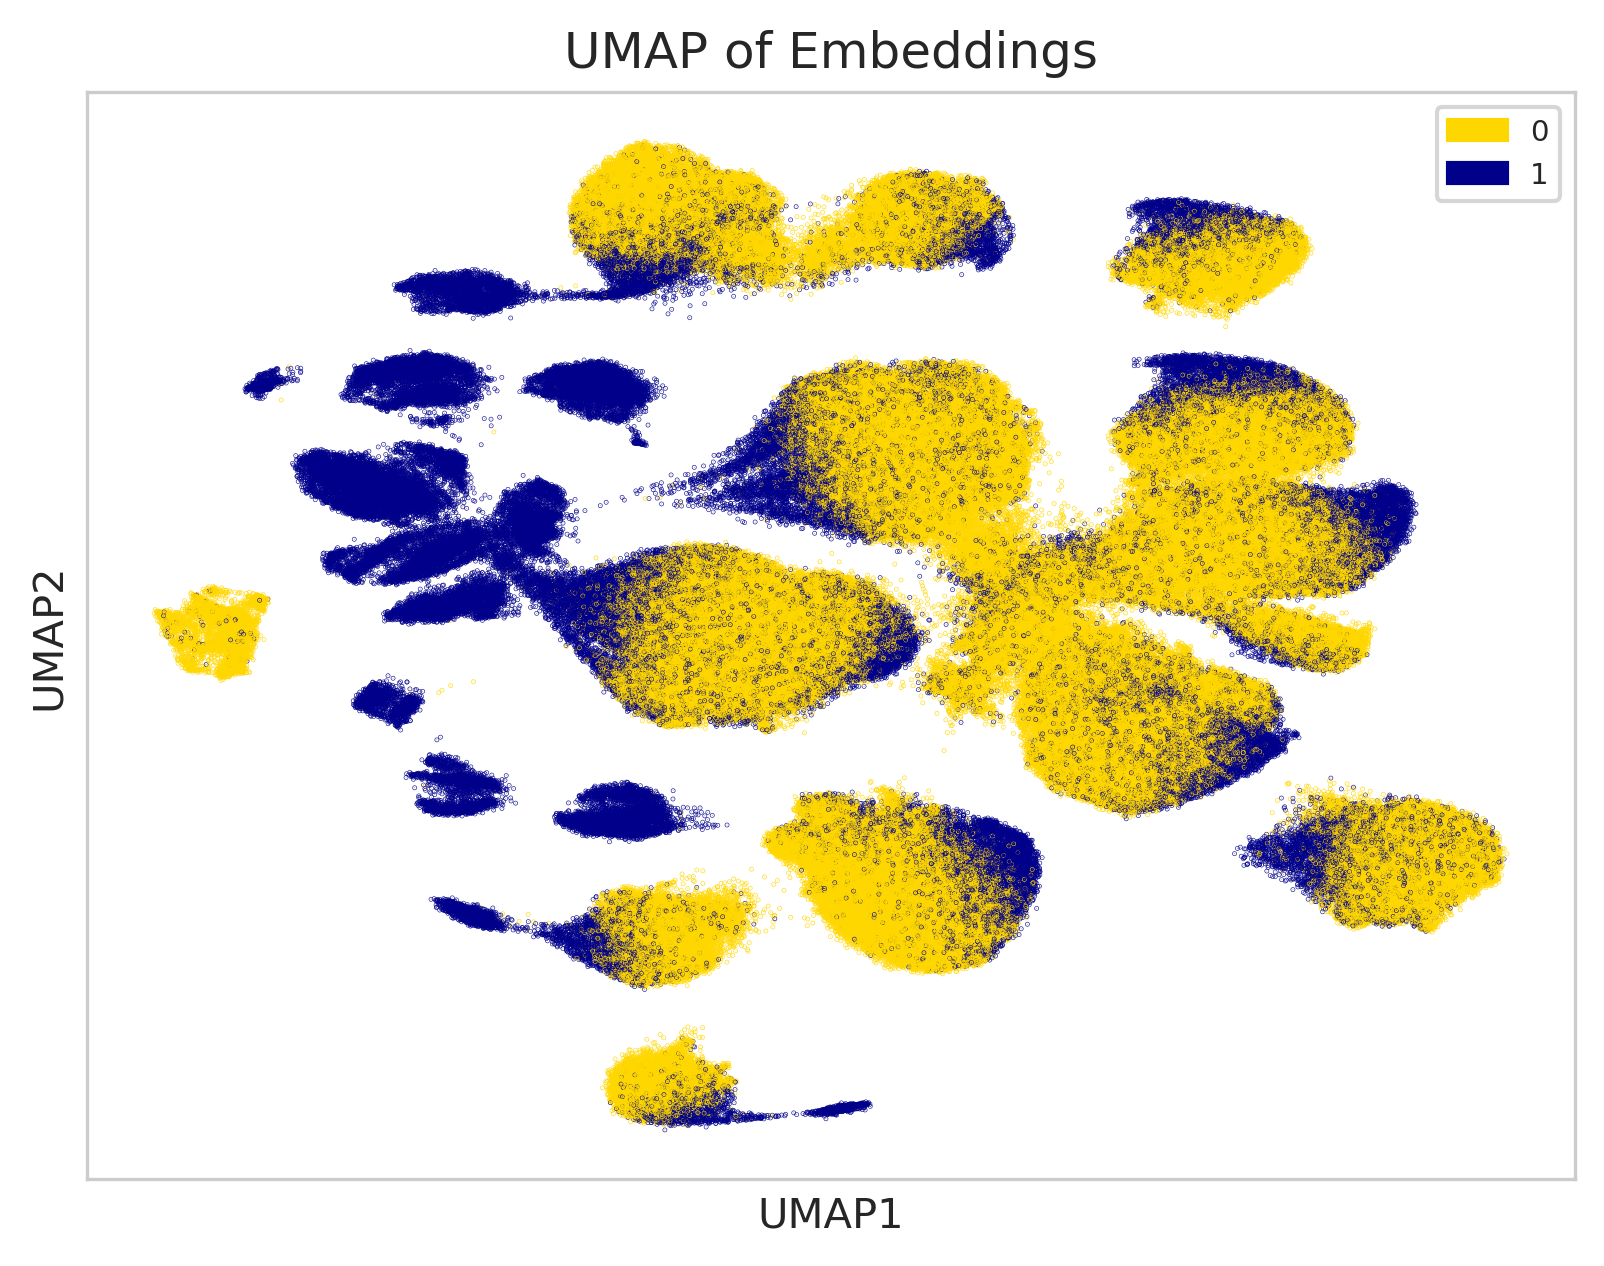

In [46]:
# Plot embeddings
embed_wrap.plot_embedding(
    color_embed=color_label,
    color_map=cmap_colors,
    title=title,
    legend_size=3,
    plot_pdf_path=os.path.join(PLOT_DIR, pdf_title),
)